# Pneumonia Classification with Deep Learning
## Convolutional Neural Networks

### Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, regularizers
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense
from keras import layers
from keras.constraints import maxnorm

import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(123)

### Load Data

In [3]:
#create directories

main_dir = "../input/chest-xray-pneumonia/chest_xray/"

train_data_dir = main_dir + "train/"
val_data_dir = main_dir + "val/"
test_data_dir = main_dir + "test/"

train_norm = train_data_dir + 'NORMAL/'
train_pneum = train_data_dir + 'PNEUMONIA/'

val_norm = val_data_dir + 'NORMAL/'
val_pneum = val_data_dir + 'PNEUMONIA/'

test_norm = test_data_dir + 'NORMAL/'
test_pneum = test_data_dir + 'PNEUMONIA/'

os.listdir(main_dir)

['chest_xray', '__MACOSX', 'val', 'test', 'train']

In [4]:
print("Number of cases in training set:",len(os.listdir(train_pneum)) + len(os.listdir(train_norm)))
print("Number of cases in validation set:",len(os.listdir(val_pneum)) + len(os.listdir(val_norm)))
print("Number of cases in test set:",len(os.listdir(test_pneum)) + len(os.listdir(test_norm)))

Number of cases in training set: 5216
Number of cases in validation set: 16
Number of cases in test set: 624


In [5]:
#perform Image Augmentation to normalize and increase amount of data
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir, 
        target_size=(180, 180), batch_size = 624,) 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_data_dir, 
        target_size=(180, 180), batch_size = 16)

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(180, 180), batch_size=5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


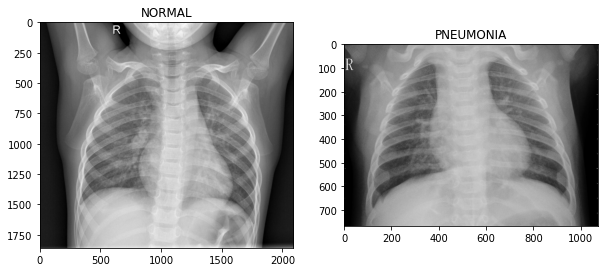

In [6]:
#samples from each class
sample_n = 'IM-0115-0001.jpeg'
img_normal = load_img(("../input/chest-xray-pneumonia/chest_xray/train/NORMAL/") + sample_n)

sample_p = 'person1000_virus_1681.jpeg'
img_pneumonia = load_img("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/" + sample_p)
    
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_normal)
axs[0].set_title("NORMAL")
axs[1].imshow(img_pneumonia)
axs[1].set_title("PNEUMONIA");

In [7]:
#forming image and label datasets partitioned into train, test, and validation sets

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [8]:
#checking shapes for each set and class partitions

m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 5216
Number of testing samples: 624
Number of validation samples: 16
train_images shape: (5216, 180, 180, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 180, 180, 3)
test_labels shape: (624, 2)
val_images shape: (16, 180, 180, 3)
val_labels shape: (16, 2)


In [9]:
def visualize_training_results(results):
    
    """
    Function to visualize loss and accuracy across epochs. 
    Visualizes metrics specifically on training data.
    Will display metrics only within learned epochs (adheres to early callback).
    """
    
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

#### Sources for above code:
- [Feyza Ozkefe](https://www.kaggle.com/feyzazkefe/pneumonia-detection-using-cnn-89-42-acc)
- [Flatiron School](https://github.com/learn-co-curriculum/dsc-convolutional-neural-networks-codealong)

## Convolutional Neural Network

In [10]:
#using image sizes that were used in Ozkefe's notebook
train_img = train_images.reshape(-1, 180, 180, 3)
val_img = val_images.reshape(-1, 180, 180, 3)
test_img = test_images.reshape(-1, 180, 180, 3)

train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

#cnn input shape
cnn_input_shape = (180, 180, 3)

print(f"Train set of images shape: {train_img.shape}")
print(f"Test set of images shape: {test_img.shape}")
print(f"Validation set of images shape: {val_img.shape}")

Train set of images shape: (5216, 180, 180, 3)
Test set of images shape: (624, 180, 180, 3)
Validation set of images shape: (16, 180, 180, 3)


In [11]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

### Baseline CNN

In [12]:
cnn_b = Sequential()

cnn_b.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=cnn_input_shape))
cnn_b.add(MaxPooling2D(pool_size=(2, 2)))

cnn_b.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn_b.add(MaxPooling2D(pool_size=(2, 2)))

cnn_b.add(Dense(128, activation='relu'))

cnn_b.add(Flatten())
cnn_b.add(Dense(1)) #1 node in output layer for binary classification
cnn_b.add(Activation('sigmoid')) #binary classification

cnn_b.compile(loss='binary_crossentropy',
           optimizer='Adam',
           metrics=['acc'])

cnn_b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dense (Dense)                (None, 45, 45, 128)       4224      
_________________________________________________________________
flatten (Flatten)            (None, 259200)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [13]:
cnn_b_results = cnn_b.fit(train_img,
                    train_y,
                    epochs=12,
                    batch_size=16,
                    validation_data=(test_img, test_y))

Epoch 1/12
326/326 [==============================] - 18s 41ms/step - loss: 0.4269 - acc: 0.8500 - val_loss: 1.2458 - val_acc: 0.7260
Epoch 2/12
326/326 [==============================] - 13s 39ms/step - loss: 0.1009 - acc: 0.9632 - val_loss: 0.8804 - val_acc: 0.7869
Epoch 3/12
326/326 [==============================] - 13s 39ms/step - loss: 0.0809 - acc: 0.9706 - val_loss: 1.4681 - val_acc: 0.7468
Epoch 4/12
326/326 [==============================] - 13s 39ms/step - loss: 0.0537 - acc: 0.9786 - val_loss: 0.8055 - val_acc: 0.7997
Epoch 5/12
326/326 [==============================] - 13s 39ms/step - loss: 0.0443 - acc: 0.9824 - val_loss: 1.3334 - val_acc: 0.7596
Epoch 6/12
326/326 [==============================] - 13s 39ms/step - loss: 0.0263 - acc: 0.9903 - val_loss: 2.8872 - val_acc: 0.7196
Epoch 7/12
326/326 [==============================] - 13s 39ms/step - loss: 0.0275 - acc: 0.9885 - val_loss: 1.7329 - val_acc: 0.7372
Epoch 8/12
326/326 [==============================] - 13s 39ms

In [14]:
train_scores = cnn_b.evaluate(train_img, train_y)
test_scores = cnn_b.evaluate(test_img, test_y)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

20/20 [==============================] - 1s 57ms/step - loss: 4.1359 - acc: 0.7404
Loss of the training model: 0.01
Training Accuracy: 99.65%


Loss of the testing model: 4.14
Test Accuracy: 74.04%


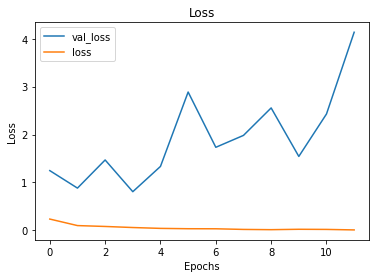

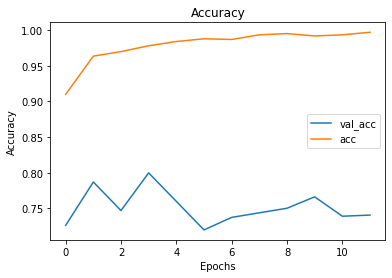

In [15]:
visualize_training_results(cnn_b_results)

### Improved Model

This CNN employed multiple techniques in order to help alleviate overfitting. The model contains one hidden convolutional layer and one hidden fully-connected (Dense) layer. The input layer contains a combination of L1 and L2 regularization and constrained network weights, which were also used in the Dense layer. Additionally, early stopping was used, which provided significant assistance in alleviating overfitting.

In [20]:
cnn = Sequential()
cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=cnn_input_shape, 
               kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0005, l2=0.0005),
               kernel_initializer='he_normal',
               kernel_constraint=maxnorm(5), padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))
cnn.add(tf.keras.layers.BatchNormalization())

cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))

cnn.add(Dense(128, activation='relu', kernel_constraint=maxnorm(5)))
cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Dense(1)) #1 node in output layer for binary classification
cnn.add(Dropout(0.5))
cnn.add(Activation('sigmoid')) #binary classification

cnn.compile(loss='binary_crossentropy',
           optimizer='Adam',
           metrics=['acc'])

cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 90, 90, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 45, 45, 32)       

In [21]:
cnn_results = cnn.fit(train_img,
                    train_y,
                    epochs=12,
                    batch_size=32,
                    callbacks=early_stopping_cb,
                    validation_data=(test_img, test_y))

Epoch 1/12
163/163 [==============================] - 14s 83ms/step - loss: 3.8968 - acc: 0.7596 - val_loss: 0.7970 - val_acc: 0.7997
Epoch 2/12
163/163 [==============================] - 13s 80ms/step - loss: 0.6818 - acc: 0.8375 - val_loss: 0.8227 - val_acc: 0.8381
Epoch 3/12
163/163 [==============================] - 13s 81ms/step - loss: 0.6662 - acc: 0.8443 - val_loss: 0.7416 - val_acc: 0.8029
Epoch 4/12
163/163 [==============================] - 13s 80ms/step - loss: 0.5932 - acc: 0.8478 - val_loss: 0.6331 - val_acc: 0.8574
Epoch 5/12
163/163 [==============================] - 13s 81ms/step - loss: 0.6638 - acc: 0.8309 - val_loss: 0.7799 - val_acc: 0.6458
Epoch 6/12
163/163 [==============================] - 13s 81ms/step - loss: 0.5584 - acc: 0.8452 - val_loss: 0.7417 - val_acc: 0.6827
Epoch 7/12
163/163 [==============================] - 13s 80ms/step - loss: 0.5827 - acc: 0.8412 - val_loss: 0.6599 - val_acc: 0.7965


In [22]:
train_scores = cnn.evaluate(train_img, train_y)
test_scores = cnn.evaluate(test_img, test_y)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

20/20 [==============================] - 7s 293ms/step - loss: 0.6331 - acc: 0.8574
Loss of the training model: 0.59
Training Accuracy: 87.06%


Loss of the testing model: 0.63
Test Accuracy: 85.74%


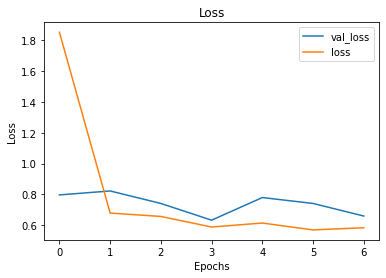

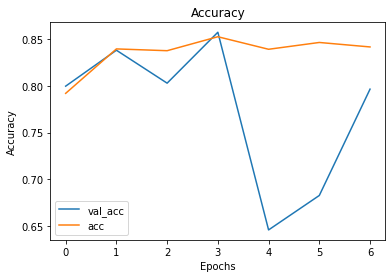

In [26]:
visualize_training_results(cnn_results)

### Predictions

In [23]:
# Saving the model for future use
cnn.save('jp_chest_xray_cnn_5.24.21') 

predicted: NORMAL


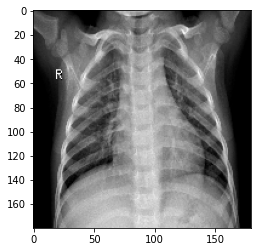

In [25]:
def predict_image(filename):
    img = load_img(filename, target_size=(180, 180))
    image = keras.preprocessing.image.img_to_array(img)
    image = image / 255.0
    image = image.reshape(1,180,180,3)
    model = load_model('jp_chest_xray_cnn_5.24.21')
    prediction = model.predict(image)
    plt.imshow(img)
    if(prediction[0] > 0.5):
        print("predicted: PNEUMONIA")
    else:
        print("predicted: NORMAL")

predict_image("../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0125-0001.jpeg")